In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy 
from scipy.signal import find_peaks

from matplotlib import colors
from matplotlib import ticker

In [2]:
import matplotlib

nice_fonts = {
    "text.usetex": False,
    "font.size": 12,
    "axes.formatter.limits": (-2, 4),
    'xtick.direction': 'in',
    'ytick.direction': 'in',
}

matplotlib.rcParams.update(nice_fonts)

c1 = '#dc2f18'
c2 = '#2d82b7'
#c3 = '#aaae8e'
c3 = '#885a89'
c4 = '#07004d'
mcols = [c2, c3, c4, 'maroon']

In [3]:
def get_channel(runNo = 24100, ch = 10, dir = "../coldbox_data/"):
    filename = dir + f"adc_data_run_{runNo}_ch_{ch}_all.npy"
    dat = np.load(filename, allow_pickle=True)
    dat = dat.astype(np.int16) # else it's numpy.int64
    return dat

def subtract_pedestal(channel):
    # np.bincount(channel[0])[6980]
    #     returns of entries in the bin 6980
    # np.argmax(np.bincount(channel[i])): 
    #     returns the value of the most populated bin for event i
    peds = np.array([np.argmax(np.bincount(channel[i])) for i in range(len(channel))])
    peds = peds[:, np.newaxis] # reshaping, eg. array([1500, 1631, 1483]) -> array([[1500], [1631], [1483]])
    return channel - peds, peds
    

def quick_plot(data, title, axis):
    axis.plot(data.transpose())
    axis.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
    axis.set_ylabel(r"$\mathrm{\bf ADC\ counts}$")
    axis.set_title(title);

In [4]:
# neutrons
n = get_channel(runNo = 25036, ch = 40)
print(f'original shape: {n.shape}')
good_n = n[:, 3000:6000].copy()
print(f'selection: {good_n.shape}')
n, peds_n = subtract_pedestal(n)
good_n, peds_good_n = subtract_pedestal(good_n)
# n.shape
## 1000/65536 = 0.0152587890625
## one clock tick is about 15 ns

original shape: (16600, 65536)
selection: (16600, 3000)


In [5]:
# cosmics
ch_nb = 40
cr = get_channel(runNo = 25066, ch = ch_nb)
good_c = cr[:, 3000:6000].copy()
print(f'original shape: {cr.shape}')
print(f'selection: {good_c.shape}')
cr, peds_cr = subtract_pedestal(cr)
good_c, peds_good_c = subtract_pedestal(good_c)
# cr.shape ## here tirgger every 4ms

original shape: (4200, 262144)
selection: (4200, 3000)


# Pedestals

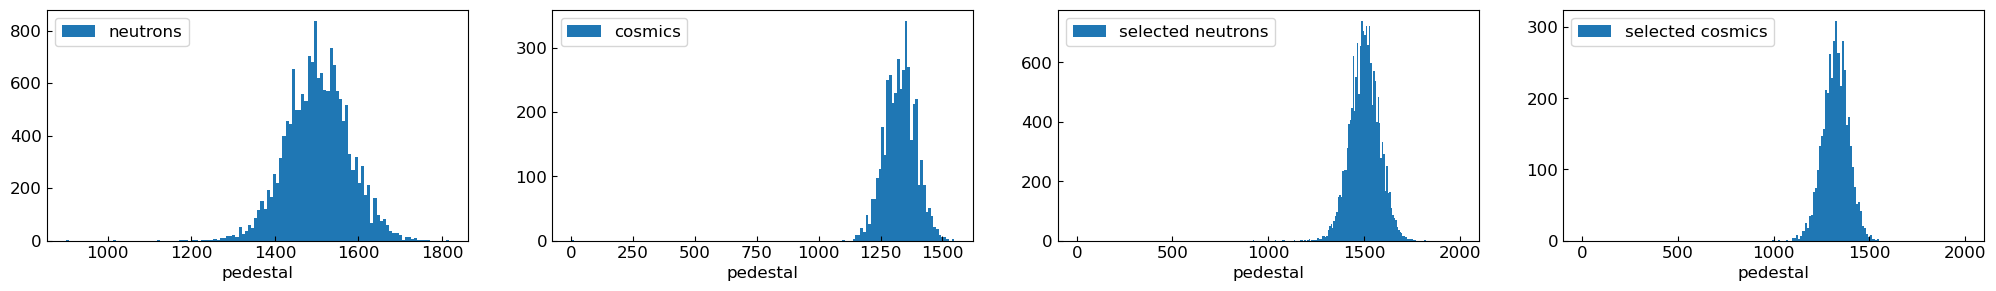

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(25, 3)) #dpi=200
ax = axs[0]
ax.hist(peds_n,  bins='auto', label='neutrons');
ax.legend(loc='upper left');
ax.set_xlabel('pedestal');
ax = axs[1]
ax.hist(peds_cr, bins='auto', label='cosmics');
ax.legend(loc='upper left');
ax.set_xlabel('pedestal');
ax = axs[2]
ax.hist(peds_good_n, bins='auto', label='selected neutrons', range=(0, 2000));
ax.legend(loc='upper left');
ax.set_xlabel('pedestal');
ax = axs[3]
ax.hist(peds_good_c, bins='auto', label='selected cosmics', range=(0, 2000));
ax.legend(loc='upper left');
ax.set_xlabel('pedestal');


Text(0.5, 0, 'pedestal')

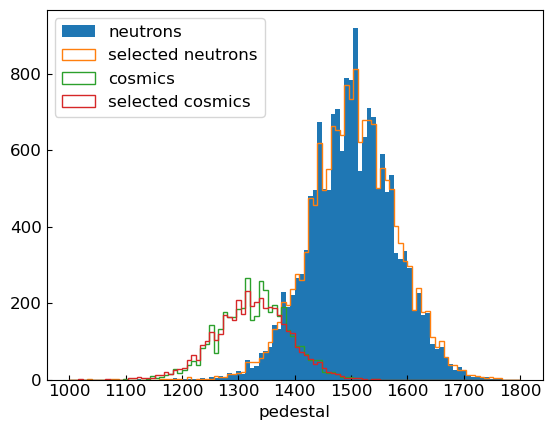

In [8]:
plt.hist(peds_n,  bins=100, range=(1000, 1800), label='neutrons');
plt.hist(peds_good_n,  bins=100, range=(1000, 1800), histtype='step', label='selected neutrons');
plt.hist(peds_cr, bins=100, range=(1000, 1800), histtype='step', label='cosmics');
plt.hist(peds_good_c, bins=100, range=(1000, 1800), histtype='step', label='selected cosmics');
plt.legend();
plt.xlabel('pedestal')

In [9]:
n_noPed  = get_channel(runNo = 25036, ch = 40)
cr_noPed = get_channel(runNo = 25066, ch = 40)


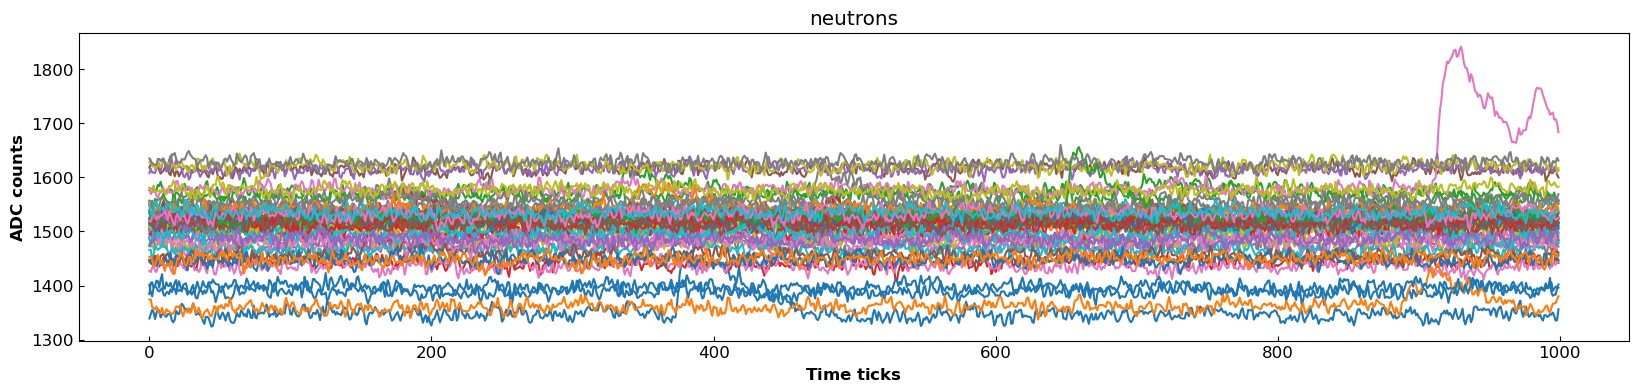

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(20, 4))
quick_plot(n_noPed[999:1050, 6000:7000], 'neutrons', axs)

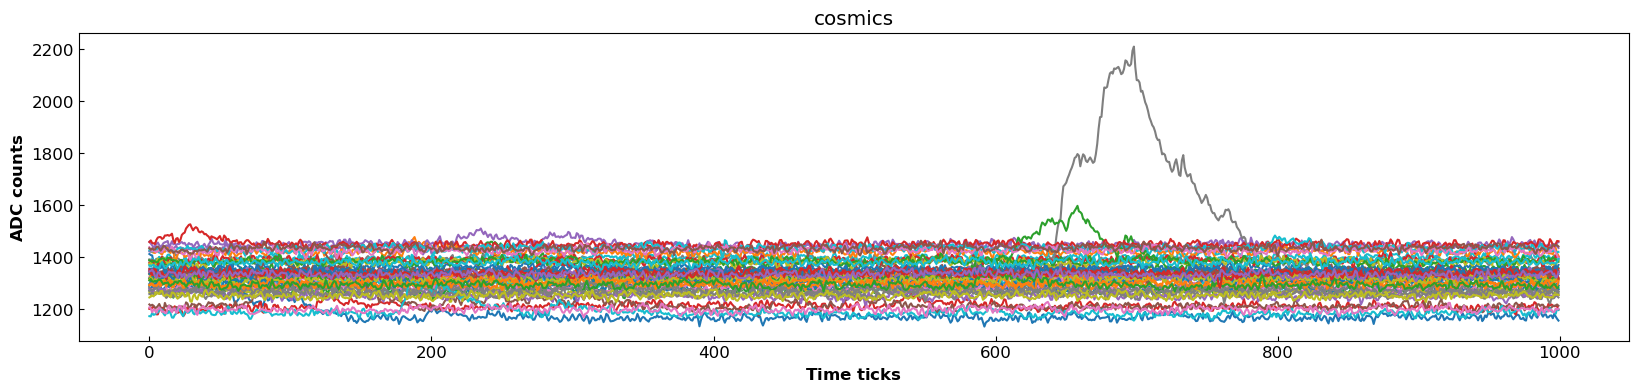

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(20, 4))
quick_plot(cr_noPed[0:50, 0:1000], 'cosmics', axs)

# Peaks

In [15]:
def get_peaks(data, h=100, d=150):
    all_peaks, all_heights = [], []
    for i in range(len(data)):
        peaks, heights = find_peaks(data[i], height=h, distance=d)
        #print(peaks, heights['peak_heights'])
        all_peaks +=list(peaks)
        all_heights += list(heights['peak_heights'])

    return np.array(all_peaks).flatten(), np.array(all_heights).flatten()

In [16]:
pn, hn   = get_peaks(n) ## peak position, peak value
print(pn.shape)
pc, hc   = get_peaks(cr)
print(pc.shape)
pgn, hgn = get_peaks(good_n) 
print(pgn.shape)
pgc, hgc = get_peaks(good_c) 
print(pgc.shape)

(319992,)
(118678,)
(32769,)
(1336,)


In [17]:
pn1k, hn1k   = get_peaks(n, h=1000) 
print(pn1k.shape)
pc1k, hc1k   = get_peaks(cr, h=1000)
print(pc1k.shape)
pgn1k, hgn1k = get_peaks(good_n, h=1000) 
print(pgn1k.shape)
pgc1k, hgc1k = get_peaks(good_c, h=1000) 
print(pgc1k.shape)

(25077,)
(16690,)
(1850,)
(185,)


## peak position

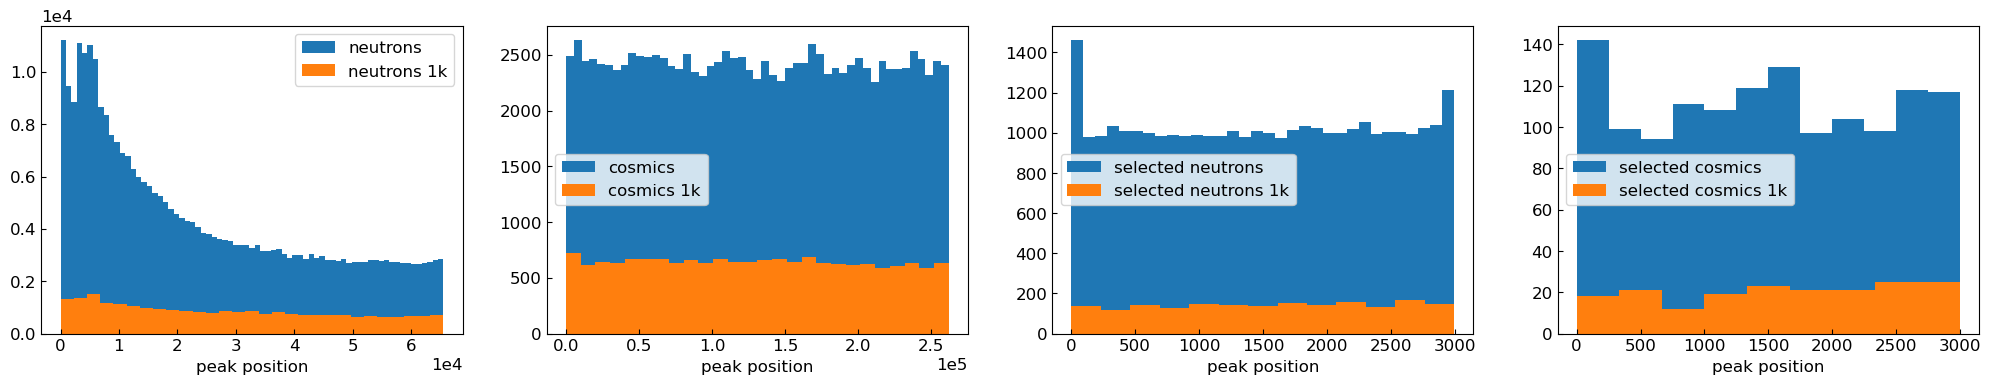

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(25, 4)) #dpi=200
ax = axs[0]
ax.hist(pn,  bins='auto', label='neutrons');
ax.hist(pn1k,  bins='auto', label='neutrons 1k');
ax.legend(loc='upper right');
ax.set_xlabel('peak position');
ax = axs[1]
ax.hist(pc, bins='auto', label='cosmics');
ax.hist(pc1k, bins='auto', label='cosmics 1k');
ax.legend(loc='center left');
ax.set_xlabel('peak position');
ax = axs[2]
ax.hist(pgn, bins='auto', label='selected neutrons');
ax.hist(pgn1k, bins='auto', label='selected neutrons 1k');
ax.legend(loc='center left');
ax.set_xlabel('peak position');
ax = axs[3]
ax.hist(pgc, bins='auto', label='selected cosmics');
ax.hist(pgc1k, bins='auto', label='selected cosmics 1k');
ax.legend(loc='center left');
ax.set_xlabel('peak position');

Text(0.5, 0, 'peak position')

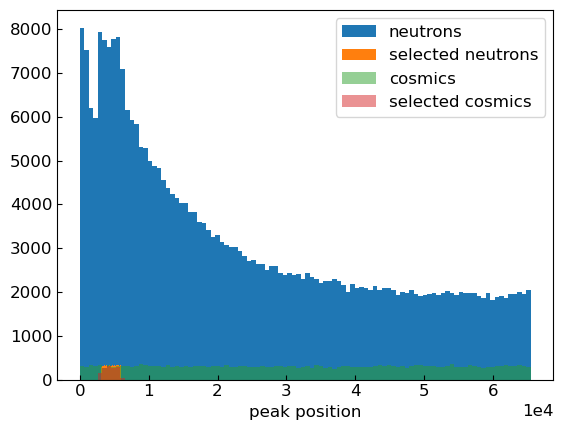

In [22]:
plt.hist(pn,  bins=100,  label='neutrons');
plt.hist(pgn+3000,  bins=100, label='selected neutrons');
plt.hist(pc, bins=100, alpha=0.5,  label='cosmics', range=(0, n.shape[1]));
plt.hist(pgc+3000, bins=100, alpha=0.5,  label='selected cosmics', range=(0, n.shape[1]));
plt.legend();
plt.xlabel('peak position')

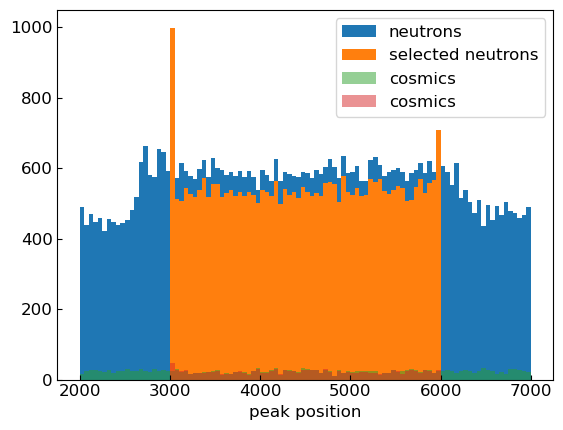

In [23]:
plt.hist(pn,  bins=100,  label='neutrons', range=(2000, 7000));
plt.hist(pgn+3000,  bins=100, label='selected neutrons', range=(2000, 7000));
plt.hist(pc, bins=100, alpha=0.5,  label='cosmics', range=(2000, 7000));
plt.hist(pgc+3000, bins=100, alpha=0.5,  label='cosmics', range=(2000, 7000));

plt.legend();
plt.xlabel('peak position');

## peak height

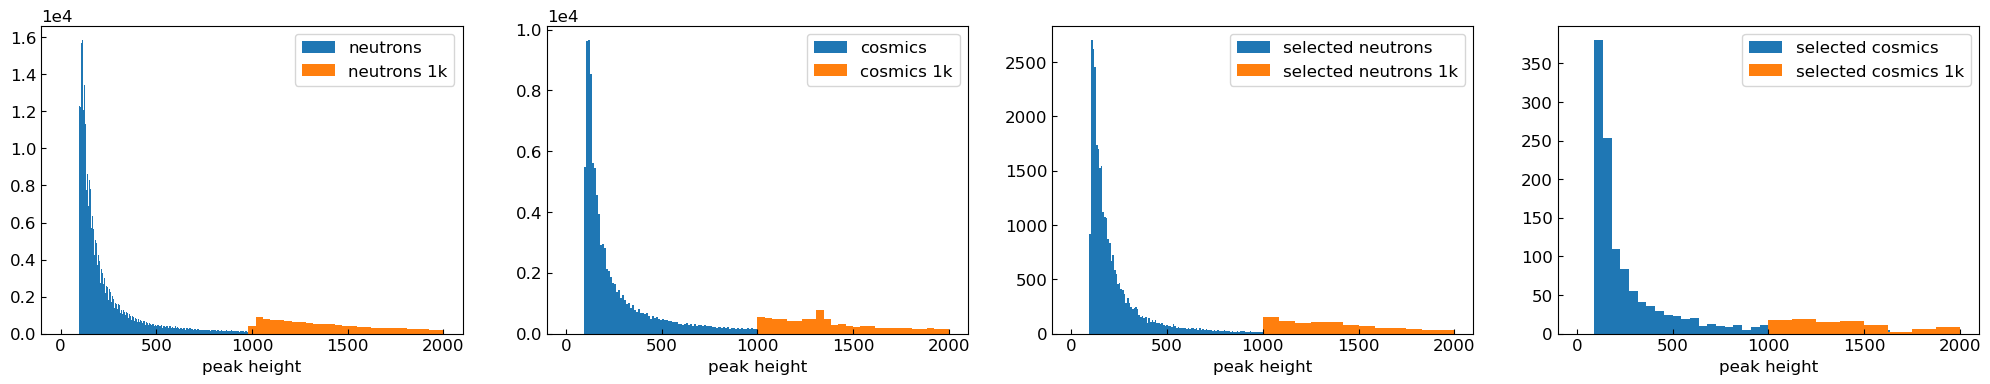

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(25, 4)) #dpi=200
rg = (0, 2000)
ax = axs[0]
ax.hist(hn,  bins='auto', label='neutrons', range=rg);
ax.hist(hn1k,  bins='auto', label='neutrons 1k', range=rg);
ax.legend(loc='upper right');
ax.set_xlabel('peak height');
ax = axs[1]
ax.hist(hc, bins='auto', label='cosmics', range=rg);
ax.hist(hc1k, bins='auto', label='cosmics 1k', range=rg);
ax.legend(loc='upper right');
ax.set_xlabel('peak height');
ax = axs[2]
ax.hist(hgn, bins='auto', label='selected neutrons', range=rg);
ax.hist(hgn1k, bins='auto', label='selected neutrons 1k', range=rg);
ax.legend(loc='upper right');
ax.set_xlabel('peak height');
ax = axs[3]
ax.hist(hgc, bins='auto', label='selected cosmics', range=rg);
ax.hist(hgc1k, bins='auto', label='selected cosmics 1k', range=rg);
ax.legend(loc='upper right');
ax.set_xlabel('peak height');

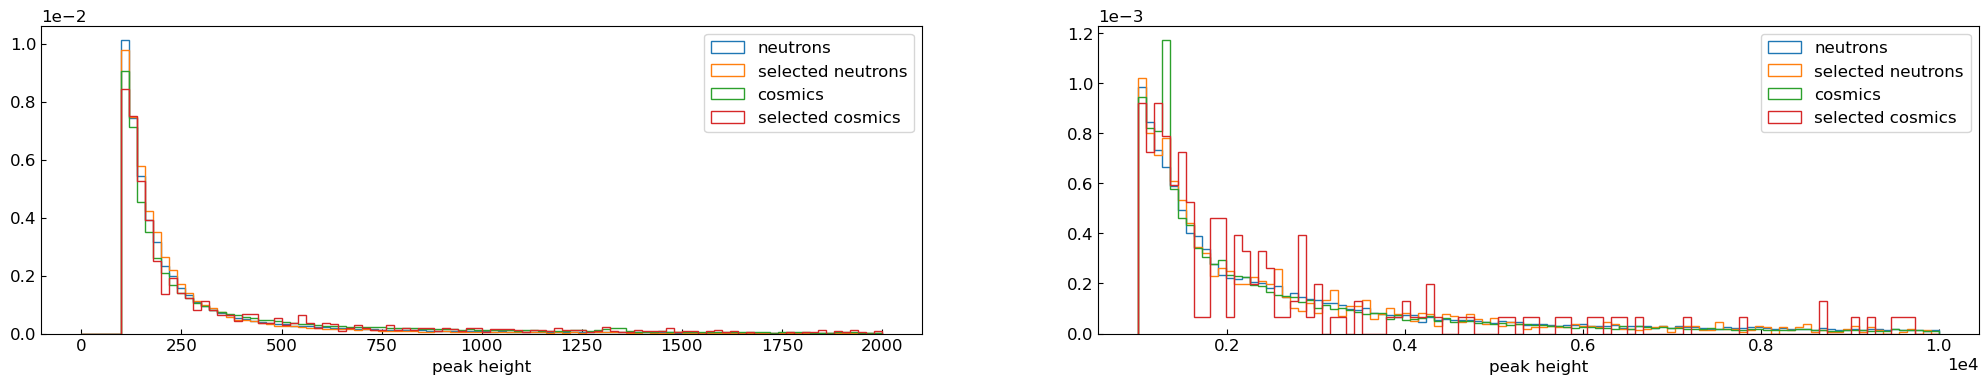

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(25, 4)) #dpi=200
ax = axs[0]
rg = (0, 2000)
den=True
ax.hist(hn,    bins=100,  histtype='step',  label='neutrons',          range=rg, density=den);
ax.hist(hgn,   bins=100,  histtype='step',  label='selected neutrons', range=rg, density=den);
ax.hist(hc,    bins=100,  histtype='step',  label='cosmics',           range=rg, density=den);
ax.hist(hgc,   bins=100,  histtype='step',  label='selected cosmics',  range=rg, density=den);
ax.legend(loc='upper right');
ax.set_xlabel('peak height');

ax = axs[1]
rg = (1000, 10000)
den=True
ax.hist(hn1k,    bins=100,  histtype='step',  label='neutrons',          range=rg, density=den);
ax.hist(hgn1k,   bins=100,  histtype='step',  label='selected neutrons', range=rg, density=den);
ax.hist(hc1k,    bins=100,  histtype='step',  label='cosmics',           range=rg, density=den);
ax.hist(hgc1k,   bins=100,  histtype='step',  label='selected cosmics',  range=rg, density=den);
ax.legend(loc='upper right');
ax.set_xlabel('peak height');

# Waveforms

In [30]:
def get_peaks2d(data, height=1000, distance=150, prominence = None, plateau_cut = 2):
    """ 
      keep the 2d structure
      i.e. find peaks per trigger record
      useful to isolate waveforms
      plateau: if there is a plateau, it's very likely because there is saturation -> try to remove these things
      returns a list of np arrays (of DIFFERENT shapes)
    """
    all_peaks, all_heights, all_plateaus = [], [], []
    for i in range(len(data)):
        peaks, heights = find_peaks(data[i], height=height, distance=distance, prominence = prominence, plateau_size = 0)
        mask = heights['plateau_sizes']<plateau_cut
        all_peaks.append(peaks[mask])
        all_heights.append(heights['peak_heights'][mask])
        all_plateaus.append(heights['plateau_sizes'][mask])

    return all_peaks, all_heights, all_plateaus

def make_peakDict(pn, hn, min_height=5000, max_height=14500, evts=None):
    """ 
      loop on trigger recs.
      apply some cuts to select good peaks
      returns a dictionary:
        - keys: trigger rec. idxs
        - values: list of np arrays of size 2, 1st entry is peak position, 2nd entry is height
    """
    peaks = {}
    if evts is None: evts = np.arange(0, len(pn), 1)
    for e in evts:
        peaks[e] = []
        for i in range(0, len(pn[e])):
            if hn[e][i]>min_height and hn[e][i]<max_height:
                peaks[e].append([pn[e][i], hn[e][i]])
    return peaks

def count_nonEmpty_entries(dictionary):
    return len([array for key, array in dictionary.items() if array])

def get_waveforms(data, data_peaks, evts=[], window_min=15, window_max=250, plot=True, title='sel'):
    if plot: fig, axs = plt.subplots(1, 1, figsize=(12, 2))
    out = {}
    # idx = 0
    for e in evts:
        idx = 0
        for m in data_peaks[e]:
            wf = data[e:e+1, m[0]-window_min:m[0]+window_max]
            # out[e, int(idx)] = wf
            out[e, int(idx)] = wf
            idx += 1
            if plot: quick_plot(wf, title, axs)
    return out

def count_peaks(list_2d):
    """
    sanity check
    """
    s=0
    for tr in list_2d:
        s+=tr.shape[0]
    return s

In [ ]:
# c_pos, c_height   = get_peaks_old(cr,     height=5000, distance=150, prominence = 100) 
# print(count_peaks(c_pos))

In [ ]:
# good_c = good_cr

In [31]:
# n_pos, n_height,n_all_plateaus    = get_peaks2d(n,      height=1000, distance=150, prominence = 100, plateau_cut = 2) 
# c_pos, c_height, c_all_plateaus   = get_peaks2d(cr,     height=1000, distance=150, prominence = 100, plateau_cut = 2) 
gn_pos, gn_height, gn_all_plateaus = get_peaks2d(good_n,  height=1000, distance=150, prominence = 100, plateau_cut = 2) 
gc_pos, gc_height, gc_all_plateaus = get_peaks2d(good_c,  height=1000, distance=150, prominence = 100, plateau_cut = 2) 


# print(count_peaks(n_pos))
# print(count_peaks(c_pos))
print(count_peaks(gn_pos))
print(count_peaks(gc_pos))


1682
157


In [32]:
# min_height is already included in find_peaks
# d_n  = make_peakDict(n_pos,  n_height,  min_height=5000, max_height=14500)
# d_c  = make_peakDict(c_pos,  c_height,  min_height=5000, max_height=14500)

d_gn = make_peakDict(gn_pos, gn_height, min_height=1000, max_height=14500)
d_gc = make_peakDict(gc_pos, gc_height, min_height=1000, max_height=14500)

# print(count_nonEmpty_entries(d_n))
# print(count_nonEmpty_entries(d_c))
print(count_nonEmpty_entries(d_gn))
print(count_nonEmpty_entries(d_gc))


1550
151


In [33]:
# non_empty_recs = {k: v for k, v in d_n.items() if v}
# n_d = get_waveforms(n, non_empty_recs, evts=non_empty_recs.keys(), window_min=100, window_max=120, title='neutrons', plot=True)
# len(n_d)

In [34]:
# non_empty_recs = {k: v for k, v in d_c.items() if v}
# c_d = get_waveforms(cr, non_empty_recs, evts=list(non_empty_recs.keys()), window_min=100, window_max=120, title='cosmics', plot=True)
# len(c_d)

1678

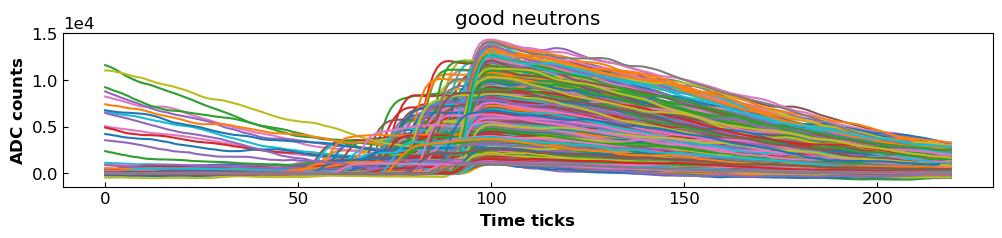

In [33]:
non_empty_recs = {k: v for k, v in d_gn.items() if v}
gn_d = get_waveforms(good_n, non_empty_recs, evts=non_empty_recs.keys(), window_min=100, window_max=120, title='good neutrons', plot=True)
len(gn_d)

157

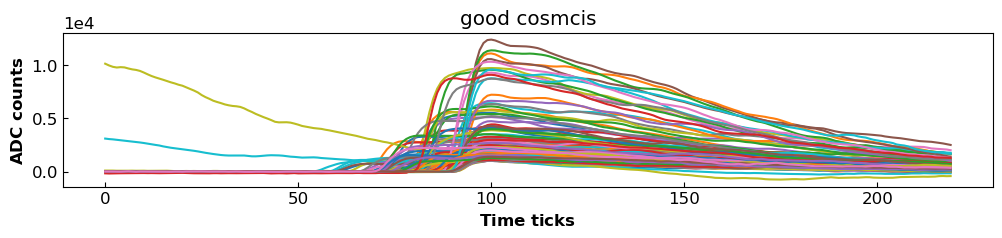

In [34]:
non_empty_recs = {k: v for k, v in d_gc.items() if v}
gn_d = get_waveforms(good_c, non_empty_recs, evts=non_empty_recs.keys(), window_min=100, window_max=120, title='good cosmcis', plot=True)
len(gn_d)

In [35]:
non_empty_recs

{8: [[2636, 1444.0]],
 21: [[2288, 5806.0]],
 45: [[1329, 1253.0]],
 99: [[2204, 1211.0]],
 103: [[2537, 3055.0]],
 117: [[25, 2739.0]],
 119: [[29, 1326.0]],
 126: [[146, 1071.0]],
 196: [[530, 1570.0]],
 198: [[2115, 1424.0]],
 214: [[2621, 1932.0]],
 235: [[453, 1827.0]],
 239: [[521, 1315.0]],
 274: [[1743, 1463.0]],
 313: [[1163, 5104.0]],
 326: [[2304, 12356.0]],
 354: [[1588, 9264.0]],
 406: [[1142, 1207.0]],
 423: [[633, 9695.0]],
 473: [[438, 1589.0]],
 475: [[1467, 5496.0]],
 493: [[2015, 11059.0]],
 502: [[1352, 4009.0]],
 541: [[1271, 4245.0]],
 575: [[1158, 2382.0]],
 582: [[1500, 1250.0]],
 584: [[1999, 1333.0]],
 618: [[2792, 3226.0]],
 620: [[1188, 1379.0]],
 650: [[1953, 1188.0]],
 676: [[2032, 1179.0]],
 721: [[10, 4665.0]],
 748: [[1559, 11348.0]],
 756: [[979, 2817.0]],
 757: [[2900, 1075.0]],
 792: [[1329, 1319.0]],
 793: [[2204, 1125.0]],
 942: [[353, 2836.0]],
 951: [[2363, 2338.0]],
 1001: [[1737, 6403.0]],
 1062: [[2355, 1148.0]],
 1106: [[926, 1067.0]],
 1113:

### Look for max and compute signal range as 10% of max

In [44]:
def get_peaks2d(data, height=100, distance=150, prominence = None, plateau_cut = 2):
    """ 
      keep the 2d structure
      i.e. find peaks per trigger record
      useful to isolate waveforms
      plateau: if there is a plateau, it's very likely because there is saturation -> try to remove these things
      returns a list of np arrays (of DIFFERENT shapes)
    """
    all_peaks, all_heights, all_plateaus = [], [], []
    for i in range(len(data)):
        peaks, heights = find_peaks(data[i], height=height, distance=distance, prominence = prominence, plateau_size = 0)
        mask = heights['plateau_sizes']<plateau_cut
        all_peaks.append(peaks[mask])
        all_heights.append(heights['peak_heights'][mask])
        all_plateaus.append(heights['plateau_sizes'][mask])

        # print(i, mask, peaks, heights['plateau_sizes'])

    return all_peaks, all_heights, all_plateaus

def get_waveforms(data, data_peaks, evts=[], window_min=15, window_max=250, plot=True, title='sel'):
    if plot: fig, axs = plt.subplots(1, 1, figsize=(12, 2))
    out = {}
    # idx = 0
    for e in evts:
        idx = 0
        for m in data_peaks[e]:
            wf = data[e:e+1, m[0]-window_min:m[0]+window_max]
            # out[e, int(idx)] = wf
            out[e, int(idx)] = wf
            idx += 1
            if plot: quick_plot(wf, title, axs)
    return out


# def get_waveforms(data, peak_positions, peak_heighs,  plot=True, title='sel'):
#     colors = ['orange', 'green', 'blue', 'red', 'black']

#     for i in range(0, len(peak_positions)):
#         axs.axvline(x = peaks[i], color = colors[i])
#         peak10 = heights['peak_heights'][i]*0.1
#         ## take abs diff -> 0 corresponds to exactly 10%, if not 0, then the minim(a) correspond to the closest values
#         difference_array = np.absolute(data-peak10)
#         ## get indices of the minima
#         indices = np.array(np.where( difference_array == difference_array.min() ))[0] ## where() returns a tuple, need to cast into np.array
#         ## select the left and right indices (w.r.t the peak position)
#         left_indices  = indices[ np.where(indices < peaks[i]) ] 
#         right_indices = indices[ np.where(indices > peaks[i]) ] 
#         left  = left_indices[-1]
#         right = right_indices[0]
#         # if left / right is empty -> throw the event out?
        
#         print()
#         print(f'peaks[{i}] = {peaks[i]}, 10% of peak = {peak10}')
#         print('difference_array', difference_array)
#         print('indices', indices)
#         print('left_indices',  left_indices)
#         print('right_indices', right_indices)
#         print(f'position of the min closest to peak, left = {left}, right = {right}')
        
#         if (i>0 and left > peaks[i-1])  or i==0: axs.axvline(x = left,    color = colors[i], linestyle='dashed')
#         if (i>0 and right < peaks[i-1]) or i==0: axs.axvline(x = right,   color = colors[i],  linestyle='dashed')


# get_waveforms(cr_test, peaks, heighs,  plot=True, title='sel'):








cr_test = good_c

c_pos_test, c_height_test, c_plateaus_test   = get_peaks2d(cr_test, height=1000, distance=150, prominence = 100, plateau_cut = 2) 
print(count_peaks(c_pos_test))
d_c_test  = make_peakDict(c_pos_test,  c_height_test,  min_height=1000, max_height=14500)
print(count_nonEmpty_entries(d_c_test))

157
151


In [45]:
# cr_test

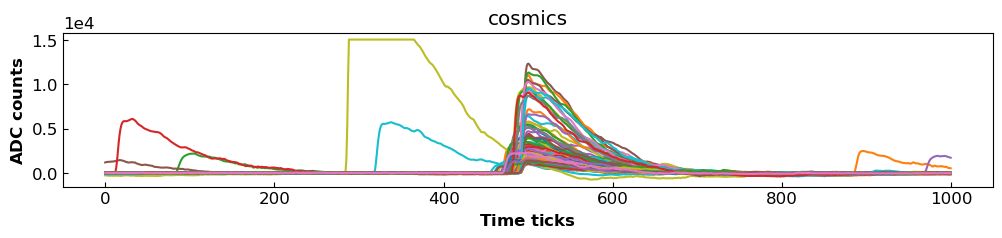

In [47]:
non_empty_recs = {k: v for k, v in d_c_test.items() if v}
# evt, evt2 = 50,60 
# evt, evt2 = 50,evt+1 
c_d_test = get_waveforms(cr_test, non_empty_recs, evts=list(non_empty_recs.keys()), window_min=500, window_max=500, title='cosmics', plot=True)
# non_empty_recs


In [50]:

# c_d_test[3,0]

In [61]:
def get_waveforms(data, peak_positions, peak_heighs,  plot=True, title='sel'):
    colors = ['orange', 'green', 'blue', 'red', 'black']

    for i in range(0, len(peak_positions)):
        axs.axvline(x = peak_positions[i], color = colors[i])
        peak_height = peak_heighs['peak_heights'][i]
        peak10 = peak_height*0.1
        ## take abs diff -> 0 corresponds to exactly 10%, if not 0, then the minim(a) correspond to the closest values
        difference_array = np.absolute(data-peak10)
        ## get indices of the minima
        indices = np.array(np.where( difference_array == difference_array.min() ))[0] ## where() returns a tuple, need to cast into np.array
        ## select the left and right indices (w.r.t the peak position)
        left_indices  = indices[ np.where(indices < peak_positions[i]) ] 
        right_indices = indices[ np.where(indices > peak_positions[i]) ] 
        left  = left_indices[-1]
        right = right_indices[0]
        # if left / right is empty -> throw the event out?
        
        print()
        print(f'peak[{i}]: pos = {peak_positions[i]}, height = {peak_height}, 10% of peak = {peak10:.2f}')
        print('difference_array', difference_array)
        print('indices', indices)
        # print('left_indices',  left_indices)
        # print('right_indices', right_indices)
        print(f'position of the min closest to peak, left = {left}, right = {right}')
        
        if (i>0 and left > peak_positions[i-1])  or i==0: axs.axvline(x = left,    color = colors[i], linestyle='dashed')
        if (i>0 and right < peak_positions[i-1]) or i==0: axs.axvline(x = right,   color = colors[i],  linestyle='dashed')



evt = [8,0]
peaks, heights = find_peaks(c_d_test[evt[0],evt[1]][0], height=1000, distance=150, prominence = 100, plateau_size = 0)
get_waveforms(c_d_test[evt[0],evt[1]][0], peaks, heights)


# fig, axs = plt.subplots(1, 1, figsize=(12, 2))
# quick_plot(c_d_test[evt[0],evt[1]], title='stuff', axis =axs)
# for p in peaks:
#     axs.axvline(x = p,   color = 'orange', linestyle='dashed',    label='locmaxs')

AttributeError: 'numpy.ndarray' object has no attribute 'axvline'


peaks[0] = 500, 10% of peak = 144.4
indices [653]
left_indices [490]
right_indices [653]
position of the min closest to peak, left = 490, right = 653

peaks[1] = 510, 10% of peak = 119.7
indices [654]
left_indices [500]
right_indices [654]
position of the min closest to peak, left = 500, right = 654

peaks[2] = 517, 10% of peak = 121.80000000000001
indices [654]
left_indices [507]
right_indices [654]
position of the min closest to peak, left = 507, right = 654

peaks[3] = 521, 10% of peak = 123.80000000000001
indices [654]
left_indices [511]
right_indices [654]
position of the min closest to peak, left = 511, right = 654

peaks[4] = 525, 10% of peak = 114.5
indices [655]
left_indices [515]
right_indices [655]
position of the min closest to peak, left = 515, right = 655


IndexError: list index out of range

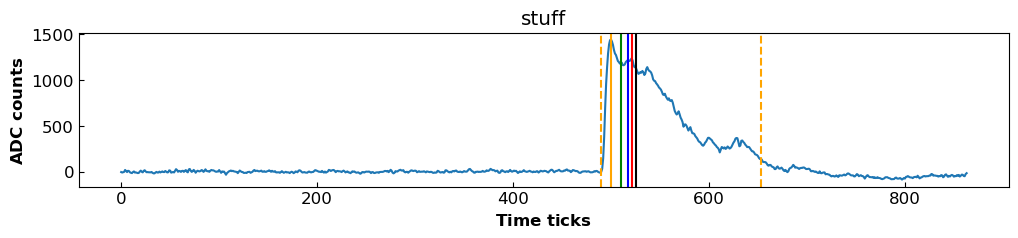

### improve peak finding


peaks[0] = 9, 10% of peak = 2.0
difference_array [ 2.  0.  2.  1.  2.  3.  4.  5.  6. 18.  6.  5.  8.  4.  2.  0.  2.  3.]
indices [ 1 15]
left_indices [1]
right_indices [15]
position of the min closest to peak, left = 1, right = 15


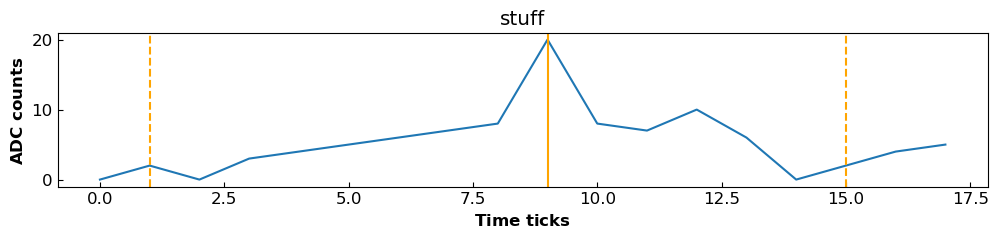

In [128]:
data = np.array([0, 2, 0, 3, 4, 5, 6, 7, 8, 20, 8, 7, 10, 6, 0, 2, 4, 5])

peaks, heights = find_peaks(data, height=5, distance=None, prominence = None, plateau_size = 0)

fig, axs = plt.subplots(1, 1, figsize=(12, 2))
quick_plot(data, title='stuff', axis =axs)
colors = ['orange', 'green', 'blue', 'red', 'black']
# for i in range(0, len(peaks)):
for i in range(0, 1):
    axs.axvline(x = peaks[i], color = colors[i])
    peak10 = heights['peak_heights'][i]*0.1
    ## take abs diff -> 0 corresponds to exactly 10%, if not 0, then the minim(a) correspond to the closest values
    difference_array = np.absolute(data-peak10)
    ## get indices of the minima
    indices = np.array(np.where( difference_array == difference_array.min() ))[0] ## where() returns a tuple, need to cast into np.array
    ## select the left and right indices (w.r.t the peak position)
    left_indices  = indices[ np.where(indices < peaks[i]) ] 
    right_indices = indices[ np.where(indices > peaks[i]) ] 
    left  = left_indices[-1]
    right = right_indices[0]
    # if left / right is empty -> throw the event out?
    
    print()
    print(f'peaks[{i}] = {peaks[i]}, 10% of peak = {peak10}')
    print('difference_array', difference_array)
    print('indices', indices)
    print('left_indices',  left_indices)
    print('right_indices', right_indices)
    print(f'position of the min closest to peak, left = {left}, right = {right}')
    
    if (i>0 and left > peaks[i-1])  or i==0: axs.axvline(x = left,    color = colors[i], linestyle='dashed')
    if (i>0 and right < peaks[i-1]) or i==0: axs.axvline(x = right,   color = colors[i],  linestyle='dashed')
    


In [94]:
peak_pos = 12
indices = np.array([ 0,  1,  2, 14, 15])
# indices[np.where(indices < peak_pos)]
# indices[ np.where(indices < peak_pos) ] 

array([0, 1, 2])

In [ ]:
# The height parameter specifies the minimum height of a peak to be detected, 
# the distance parameter specifies the minimum distance between adjacent peaks 
# the prominence is a quasi-signal to noise ratio parameter. 

## With real waveforms

In [119]:
def find_waveforoms(data, peaks, heights, threshold=0.1, nTT_left=10, plot=False, verbose=False):
    """ 
      try to isolate the waveform using peak height
      threshold (between 0 and 1): value above (below) which the left (right) window is selected
      special cases:
       sometimes the rise time is very sharp (smaller than 1 time tick), in that case, we need to adapt the strategy
        nTT_left: the begining of the window on the left will be peak position - nTT_left
        MAYBE WE CAN DO SOMETHING MORE CLEVER?
       I DON'T KNOW IF WE HAVE ISSUES ON THE RIGHT SIDE
      
    """
    dic = {'idx1': [], 'idx2': [], 'left': [], 'right': [], 'peak': []}
    if plot:
        fig, axs = plt.subplots(1, 1, figsize=(12, 2))
        quick_plot(data, title='waveform finding', axis =axs)
        colors = ['orange', 'green', 'blue', 'red', 'black']

    for i in range(0, len(peaks)):
    # for i in range(0, 1):
        dic['peak'].append(peaks[i])
        if plot: axs.axvline(x = peaks[i], color = colors[i])
        peak10 = heights['peak_heights'][i]*threshold
        ## take abs diff -> 0 corresponds to exactly 10% (if threshold = 0.1), if not 0, then the minim(a) correspond to the closest values
        difference_array = np.absolute(data-peak10)
        ## get indices of the minima
        indices = np.array(np.where( difference_array == difference_array.min() ))[0] ## where() returns a tuple, need to cast into np.array
        ## select the left and right indices (w.r.t the peak position)
        left_indices  = indices[ np.where(indices < peaks[i]) ] 
        if np.any(left_indices)==False: 
            left_indices = [peaks[i]-nTT_left]
        right_indices = indices[ np.where(indices > peaks[i]) ] 
        if np.any(left_indices):  
            left  = left_indices[-1]
            dic['left'].append(left)
        else: 
            dic['left'].append(np.nan)
        if np.any(right_indices): 
            right = right_indices[0]
            dic['right'].append(right)
        else: 
            dic['right'].append(np.nan)

        if verbose:
            print()
            print(f'peaks[{i}] = {peaks[i]}, 10% of peak = {peak10}')
            print('indices', indices)
            if np.any(left_indices):  print('left_indices',  left_indices)
            if np.any(right_indices): print('right_indices', right_indices)
            l_txt, r_txt = '', ''
            if np.any(left_indices):  l_txt = f'left = {left}' 
            if np.any(right_indices): r_txt = f'right = {right}'
            print(f'position of the min closest to peak, {l_txt}, {r_txt}')

        if plot:
            if (np.any(left_indices))  and ((i>0 and left > peaks[i-1])  or i==0): axs.axvline(x = left,    color = colors[i], linestyle='dashed')
            if (np.any(right_indices)) and ((i>0 and right < peaks[i-1]) or i==0): axs.axvline(x = right,   color = colors[i],  linestyle='dashed')
        
    return dic


peaks[0] = 500, 10% of peak = 144.4
indices [653]
left_indices [490]
right_indices [653]
position of the min closest to peak, left = 490, right = 653

peaks[0] = 500, 10% of peak = 580.6
indices [623]
left_indices [490]
right_indices [623]
position of the min closest to peak, left = 490, right = 623

peaks[0] = 500, 10% of peak = 125.30000000000001
indices [625]
left_indices [490]
right_indices [625]
position of the min closest to peak, left = 490, right = 625


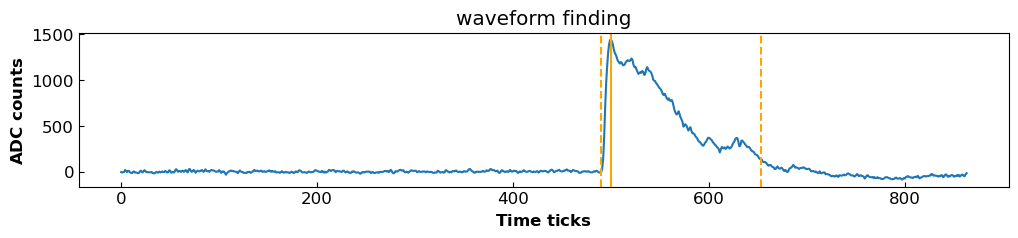

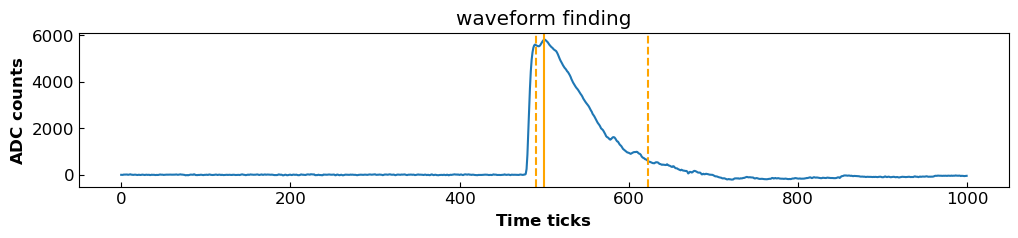

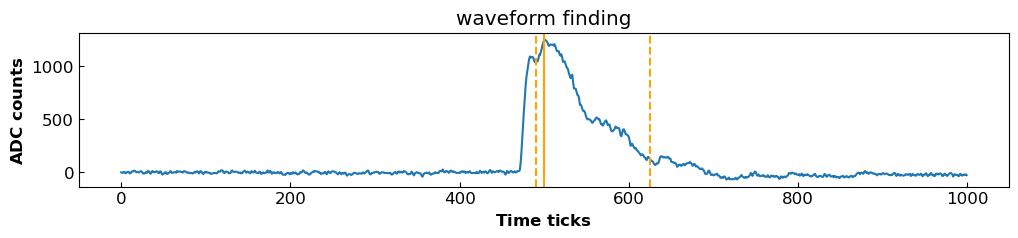

In [140]:
evts =  np.array(list(c_d_test.keys()))[0:3]

for evt in evts:
    data = c_d_test[evt[0],evt[1]][0]
    peaks, heights = find_peaks(data, height=1000, distance=150, prominence = None, plateau_size = 0)
    find_waveforoms(data, peaks, heights, threshold=0.1, nTT_left=10, plot=True, verbose=True)

In [134]:
# np.array(list(c_d_test.keys()))
# c_d_test.keys()[0]

TypeError: 'dict_keys' object is not subscriptable

# Integrals of prompt and slow components

decay time of the singlet: $\tau_1 \approx 7~\mathrm{ns}$

decay time of the triplet : $\tau_2 \approx 1.5~\mu\mathrm{s}$

Creus: 

$$
IPH = IPHA + IPHB = \sum_{t_{\mathrm{peak}} - 20~\mathrm{ns}}^{t_{\mathrm{peak}} + 30~\mathrm{ns}} U(t)~\Delta t + \sum_{t_{\mathrm{peak}} + 31~\mathrm{ns}}^{t_{\mathrm{peak}} + 3\tau_2} U(t)~\Delta t
$$

$U(t)$: signal amplitude

$\tau_2$: decay time of the triplet state 

$\Delta t$: sampling time


The integration of the first 50 ns of signal is sufficient to integrate the prompt signal and is denoted by IPHA. The time integration for the slow part of the signal is chosen at $3\tau_2$ which contains most of the part of the triplet state (IPHB).